# Setup

In [1]:
# Make sure to change this path to your local version, or otherwise comment out the noted line in the next cell
path = '/Library/Fonts/Arial Unicode.ttf'

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.patches import ConnectionPatch

from IPython.display import display, clear_output

# If the font should not be changed, comment out the next two lines:
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

single_col = 8.9 # cm
double_col = 18.3 # cm
def cm2inch(value):
    return value/2.54
FS = 18
LS = 18
MS = 10
MEW= 1.5

%matplotlib inline

# Loading the data and defining the probability function

In [14]:
D_lsv44_17 = 2.444 * u.kpc

lxlr_lsv44_17 = np.genfromtxt('./FigureData/lxlr.dat', unpack=True)

lx_05_10_lsv44_17 = (4*np.pi*(lxlr_lsv44_17[1]*u.erg/u.s/u.cm**2)*(D_lsv44_17**2)).to(u.erg / u.s).value

lr_lsv44_17 = (4*np.pi*(lxlr_lsv44_17[2]*u.microJansky)*(6.0 * u.GHz)*(D_lsv44_17**2)).to(u.erg / u.s).value
dlr_lsv44_17 = (4*np.pi*(lxlr_lsv44_17[3]*u.microJansky)*(6.0 * u.GHz)*(D_lsv44_17**2)).to(u.erg / u.s).value

uplims = lxlr_lsv44_17[4]
nondet = (-1*(uplims - 1.0)).astype('int')
delta = nondet

In [15]:
def prob(Lr, dLr, Lx, detected, pars, Lr0, Lx0):
    
    xi, beta = pars
    
    P = 1.
    
    for i in range(len(Lr)):
        Modeli = Lr0 * xi * ((Lx[i]/Lx0)**beta)
        
        if delta[i]:
            P = P * ST.norm.pdf(x=Lr[i], loc=Modeli, scale=dLr[i])
        else:
            P = P * ST.norm.cdf(x=Lr[i], loc=Modeli, scale=dLr[i])
            
    return P

In [16]:
lx0 = 8.28e36
lr0 = 3.72e28

# Fitting

In [32]:
# Note: while the routines below are highly inefficient and can likely be optimized in several ways, the low number
# of parameters and of data points means that efficiency is not a limiting factor in the analysis. 

# Define the considered range in the two parameters and the considered values:
Xi_edges = np.logspace(np.log10(1e-2), np.log10(1e-1), 501, endpoint=True)
Beta_edges = np.linspace(0,4,201,endpoint=True)

Xi = (Xi_edges[1:] + Xi_edges[:-1])/2.
Beta = (Beta_edges[1:] + Beta_edges[:-1])/2.

dBeta = (Beta_edges[1:] - Beta_edges[:-1])/2.
dXi = (Xi_edges[1:] - Xi_edges[:-1])/2.

# Loop over the two parameters and calculate the probability of the model for that combination of the two parameters:
Pmatrix = []
Sum_norm = 0 # Normalization
for i in range(len(Beta)):
    Beta_i = Beta[i]
    
    Ps = []
    for j in range(len(Xi)):
        xii = Xi[j]
        Pii = prob(Lr=lr_lsv44_17, dLr=dlr_lsv44_17, Lx=lx_05_10_lsv44_17, 
                   detected=[False,False,False,False,False,True,True,True,True,False],
                   pars=(xii,Beta_i),Lr0=lr0, Lx0=lx0)
        Ps.append(Pii)
        
        # Normalization update
        Sum_norm = Sum_norm + Pii * dBeta[i] * dXi[j]
       
    # Save the probabilities
    Pmatrix.append(np.asarray(Ps))
    
# Normalize    
Pmatrix = np.asarray(Pmatrix)
Pmatrix_normalised = Pmatrix / Sum_norm
Pmatrix_normalised_to_one = Pmatrix_normalised / np.amax(Pmatrix_normalised)

# Marginalize to calculate the errors: Beta
P_vs_beta = []
CDF_i = 0
CDF_beta = []
for i in range(len(Beta)):
    
    P_vs_beta.append(sum(Pmatrix2[i] * dXi))
    
    CDF_i = CDF_i + sum(Pmatrix2[i] * dXi) * dBeta[i]
    CDF_beta.append(CDF_i)
    
P_vs_beta = np.asarray(P_vs_beta)
Norm_beta = sum(P_vs_beta * dBeta)
P_vs_beta = P_vs_beta / Norm_beta

CDF_beta = CDF_beta / Norm_beta

# Calculate the errors: Beta
for i in range(len(CDF_beta)):
    
    if CDF_beta[i] < 0.16:
        Beta_low = Beta[i]
    if CDF_beta[i] < 0.84:
        Beta_high = Beta[i+1]
    if P_vs_beta[i] == max(P_vs_beta):
        Beta_mode = Beta[i]

# Marginalize to calculate the errors: Xi:
P_vs_Xi = []
CDF_i = 0
CDF_Xi = []

for i in range(len(Xi)):

    Sum_Xi = 0
    for j in range(len(Beta)):
        
        Sum_Xi = Sum_Xi + Pmatrix2[j][i] * dBeta[j]
        
    P_vs_Xi.append(Sum_Xi)
    
    CDF_i = CDF_i + Sum_Xi * dXi[i]
    CDF_Xi.append(CDF_i)
    
P_vs_Xi = np.asarray(P_vs_Xi)
Norm_Xi = sum(P_vs_Xi * dXi)
P_vs_Xi = P_vs_Xi / Norm_Xi

CDF_Xi = CDF_Xi / Norm_Xi

# Calculate the errors: Xi
for i in range(len(CDF_Xi)):
    
    if CDF_Xi[i] < 0.16:
        Xi_low = Xi[i]
    if CDF_Xi[i] < 0.84:
        Xi_high = Xi[i+1]
    if P_vs_Xi[i] == max(P_vs_Xi):
        Xi_mode = Xi[i]
        
print('Xi: 16th percentile - max - 84th percentile:', np.round(Xi_low,3), np.round(Xi_mode,3), np.round(Xi_high,3))
print('Beta: 16th percentile - max - 84th percentile:', np.round(Beta_low,2), np.round(Beta_mode,2), np.round(Beta_high,2))

Xi: 16th percentile - max - 84th percentile: 0.022 0.025 0.028
Beta: 16th percentile - max - 84th percentile: 0.97 1.25 1.91


# Plotting:

The two plots below are not shown in the paper but are included for a visual representation of the fit above.

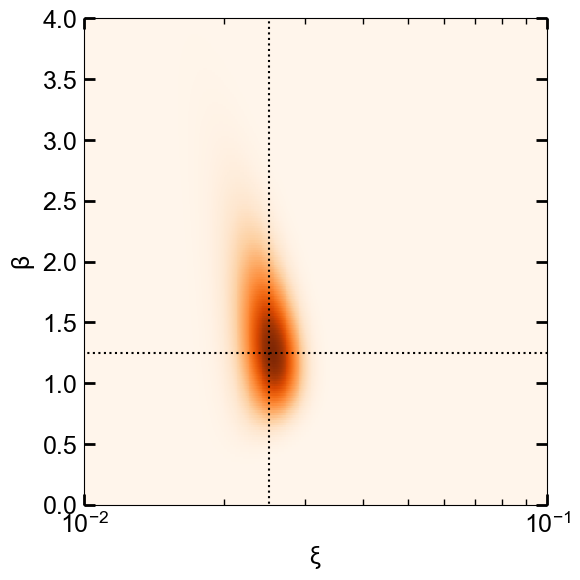

In [33]:
# 2D colormap:

Xi_axis, Beta_axis = np.meshgrid(Xi, Beta)

fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.pcolor(Xi_axis, Beta_axis, Pmatrix2_normalised, cmap='Oranges', alpha=1)
ax.plot([0.001, 10], [Beta_mode, Beta_mode], 'k:')
ax.plot([Xi_mode, Xi_mode], [-1, 10], 'k:')


ax.set_xscale('log')
ax.set_xlabel(r'$\xi$', fontsize=FS)
ax.set_ylabel(r'$\beta$', fontsize=FS)

ax.set_xlim(0.01, 0.1)
ax.set_ylim(0,4)
ax.set_xticks([0.01, 0.1], minor=False)
ax.set_xticks([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], minor=True)
ax.set_xticklabels(['','','','','','','',''], minor=True)

plt.tight_layout()
plt.show()


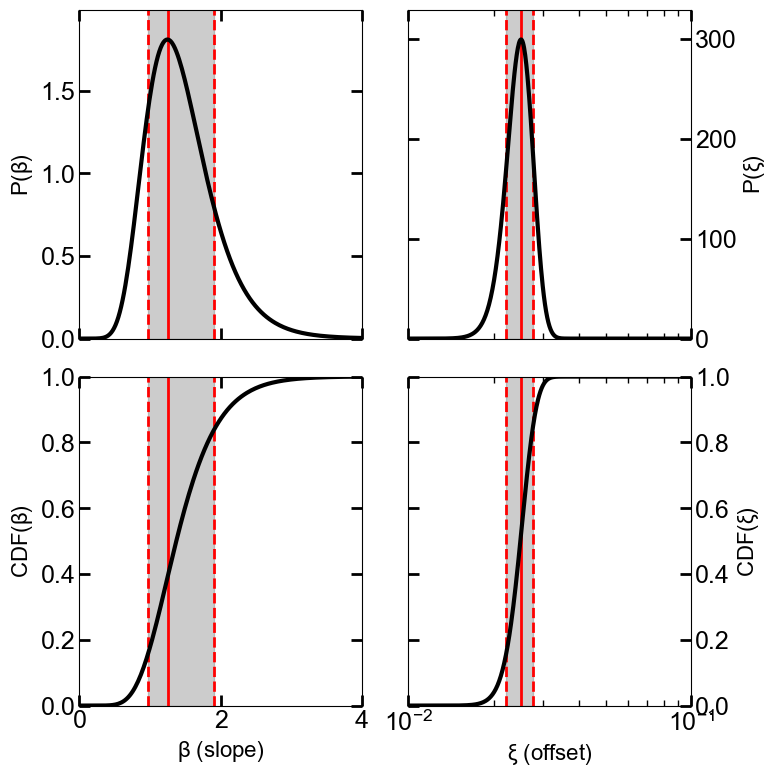

In [36]:
# Plotting the marginalized PDF and CDF for the two parameters separately:

fig = plt.figure(figsize=(2*cm2inch(10.),2*cm2inch(10)))

####### Beta:

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)

for ax in [ax1, ax2]:
    ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
    ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)

    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    
    ax.set_xlim(min(Beta_edges),max(Beta_edges))
    
    ax.plot([Beta_low, Beta_low], [0, 1e10], 'r--', lw=2)
    ax.plot([Beta_high, Beta_high], [0, 1e10], 'r--', lw=2)
    ax.plot([Beta_mode, Beta_mode], [0, 1e10], 'r-', lw=2)
    
    ax.fill_between([Beta_low, Beta_high], [0,0], [1e10,1e10], color='k', alpha=0.2, zorder=-1)
    
ax2.set_xlabel(r'$\beta$ (slope)', fontsize=FS-2)
ax1.set_ylabel(r'$P(\beta)$', fontsize=FS-2)
ax2.set_ylabel(r'CDF$(\beta)$', fontsize=FS-2)

ax1.set_ylim(0, 1.1*max(P_vs_beta))
ax2.set_ylim(0, 1)   
ax1.set_xticklabels([])
    
ax1.plot(Beta, P_vs_beta, 'k-', lw=3,zorder=5)
ax2.plot(Beta, CDF_beta, 'k-', lw=3,zorder=5)

####### Xi:

ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(224)

for ax in [ax1, ax2]:
    ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
    ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    
    ax.set_xlim(min(Xi_edges),max(Xi_edges))
    
    ax.plot([Xi_low, Xi_low], [0, 1e10], 'r--', lw=2)
    ax.plot([Xi_high, Xi_high], [0, 1e10], 'r--', lw=2)
    ax.plot([Xi_mode, Xi_mode], [0, 1e10], 'r-', lw=2)
    
    ax.set_xscale('log')
    ax.set_xticks([0.01, 0.1], minor=False)
    ax.set_xticks([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], minor=True)
    ax.set_xticklabels(['','','','','','','',''], minor=True)
    
    ax.fill_between([Xi_low, Xi_high], [0,0], [1e10,1e10], color='k', alpha=0.2, zorder=-1)
    
ax2.set_xlabel(r'$\xi$ (offset)', fontsize=FS-2)
ax1.set_ylabel(r'$P(\xi)$', fontsize=FS-2)
ax2.set_ylabel(r'CDF$(\xi)$', fontsize=FS-2)

ax1.set_ylim(0, 1.1*max(P_vs_Xi))
ax2.set_ylim(0, 1)   
ax1.set_xticklabels([])
    
ax1.plot(Xi, P_vs_Xi, 'k-', lw=3,zorder=5)
ax2.plot(Xi, CDF_Xi, 'k-', lw=3,zorder=5)

plt.tight_layout()
plt.savefig('prob.pdf')